In [20]:
import os
from pathlib import Path
PARENT_PATH = Path(os.getcwd()).parent.absolute()
import pandas as pd

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
import re

from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
import collections

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [38]:
import os
from pathlib import Path
import logging
from itertools import chain

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

sns.set_style("darkgrid")
matplotlib.rcParams['font.family'] = "serif"
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

Load data

In [22]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [23]:
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls, "Requirements List")
df.head(2)

id            Regulation                     Title / Chapter / Sub part  \
0   1  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   
1   2  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   

                Chapter / Section Article / Paragraph  \
0         2.1. General Provisions               2.1.1   
1  2.2. Management responsibility               2.2.1   

                                                Text                 Date  \
0  General Quality System Requirements […] Genera...  2013-03-28 00:00:00   
1  General Quality System Requirements […] Manage...  2013-03-28 00:00:00   

     Product Type  GxP Regulatory Requirement Type  \
0  Medical Device  GMP                        Core   
1  Medical Device  GMP                        Core   

       Full article reference Mapped to a standard?  \
0  Brazil ANVISA GMP MD 2.1.1  Mapped to a standard   
1  Brazil ANVISA GMP MD 2.2.1  Mapped to a standard   

                        Standard mapping?  
0         Regulatory Standards Management  
1  Quality Planning, \nQuality Management

Assign constants for useful columns

In [24]:
TEXT = "Text"
TARGET = "Standard mapping?"
REQUIREMENT = "Regulatory Requirement Type"
IS_MAPPED = "Mapped to a standard?"
IS_MAPPED_TRUE = "Mapped to a standard"

In [25]:
df.value_counts(IS_MAPPED)

Mapped to a standard?
No mapping              6326
Mapped to a standard    3906
dtype: int64

In [26]:
# data shape
print(f"Number of rows: {df.shape[0]}")
print(
    f"\n{sum(df[TARGET].isna())/df.shape[0]*100:.2f}",
    "percent of data doesn't get mapped to a label. We will drop these rows."
)
print(
    f"\nNumber of columns: {df.shape[1]}",
    f"\nBut only two columns, `{TEXT}`, `{REQUIREMENT}` and `{TARGET}` are of interest.",
    "\nWe will drop the remaining columns."
)


Number of rows: 10232

61.83 percent of data doesn't get mapped to a label. We will drop these rows.

Number of columns: 13 
But only two columns, `Text`, `Regulatory Requirement Type` and `Standard mapping?` are of interest. 
We will drop the remaining columns.


In [27]:
# Drop rows with no assigned labels
df = df[df[IS_MAPPED].isin([IS_MAPPED_TRUE])].copy()
# Keep only relevant columns
df = df[[TEXT, TARGET, REQUIREMENT]].copy()
df.isna().sum()

Text                           0
Standard mapping?              0
Regulatory Requirement Type    0
dtype: int64

In [28]:
# Convert target column into list of labels
df[TARGET] = \
    df[TARGET].str.lower() \
    .apply(lambda x: list(x.split("\n"))) \
    .apply(lambda x: [y.split(",") for y in x]) \
    .apply(lambda x: list(chain(*x))) \
    .apply(lambda x: [y.strip().replace("-", " ") for y in x if y.strip() != ""]).copy()

In [29]:
# Binarize target column
mlb =  MultiLabelBinarizer()
mlb.fit(df[TARGET])
df = df.join(pd.DataFrame(
    mlb.transform(df[TARGET]),
    columns=mlb.classes_,
    index=df.index
)).copy()
df.head(2)

Text  \
0  General Quality System Requirements […] Genera...   
1  General Quality System Requirements […] Manage...   

                        Standard mapping? Regulatory Requirement Type  \
0       [regulatory standards management]                        Core   
1  [quality planning, quality management]                        Core   

   acquisition and divestiture  audit inspection  calibration  capa  \
0                            0                 0            0     0   
1                            0                 0            0     0   

   change control  change controls  clinical research  ...  \
0               0                0                  0  ...   
1               0                0                  0  ...   

   regulatory standards management  risk management  samd  stability programs  \
0                                1                0     0                   0   
1                                0                0     0                   0   

   storage and distribution  training  udi and serialization  \
0                         0         0                      0   
1                         0         0                      0   

   utilities and equipment  vigilance  vmp  
0                        0          0    0  
1                        0          0    0  

[2 rows x 51 columns]

Define useful constants

In [66]:
COLOR = "darkcyan"

### Analyzing target distribution

How many regulations have multiple labels?

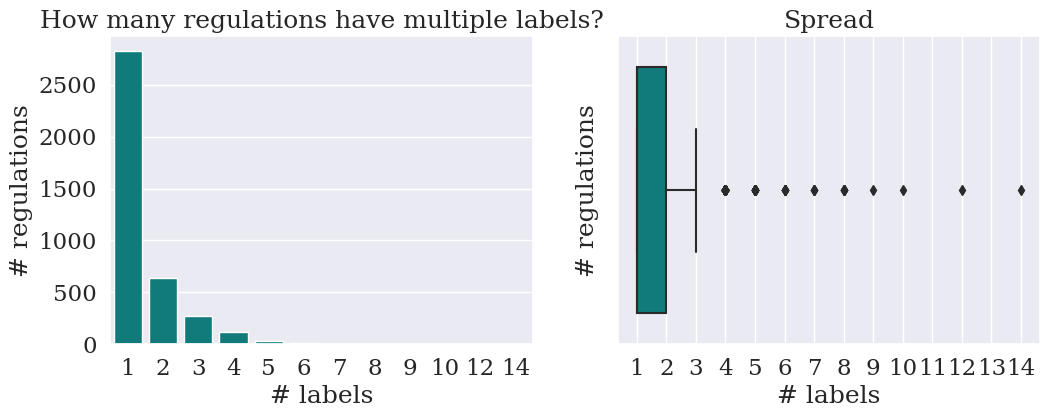

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=df[TARGET].apply(lambda x: len(x)).values, color=COLOR, ax=ax[0])
ax[0].set_xlabel("# labels")
ax[0].set_ylabel("# regulations")
ax[0].set_title("How many regulations have multiple labels?")

sns.boxplot(x=df[TARGET].apply(lambda x: len(x)).values, color=COLOR, ax=ax[1])
ax[1].set_xlabel("# labels")
ax[1].set_ylabel("# regulations")
ax[1].set_title("Spread")
ax[1].set_xticks([i for i in range(1, 15)])
plt.show();

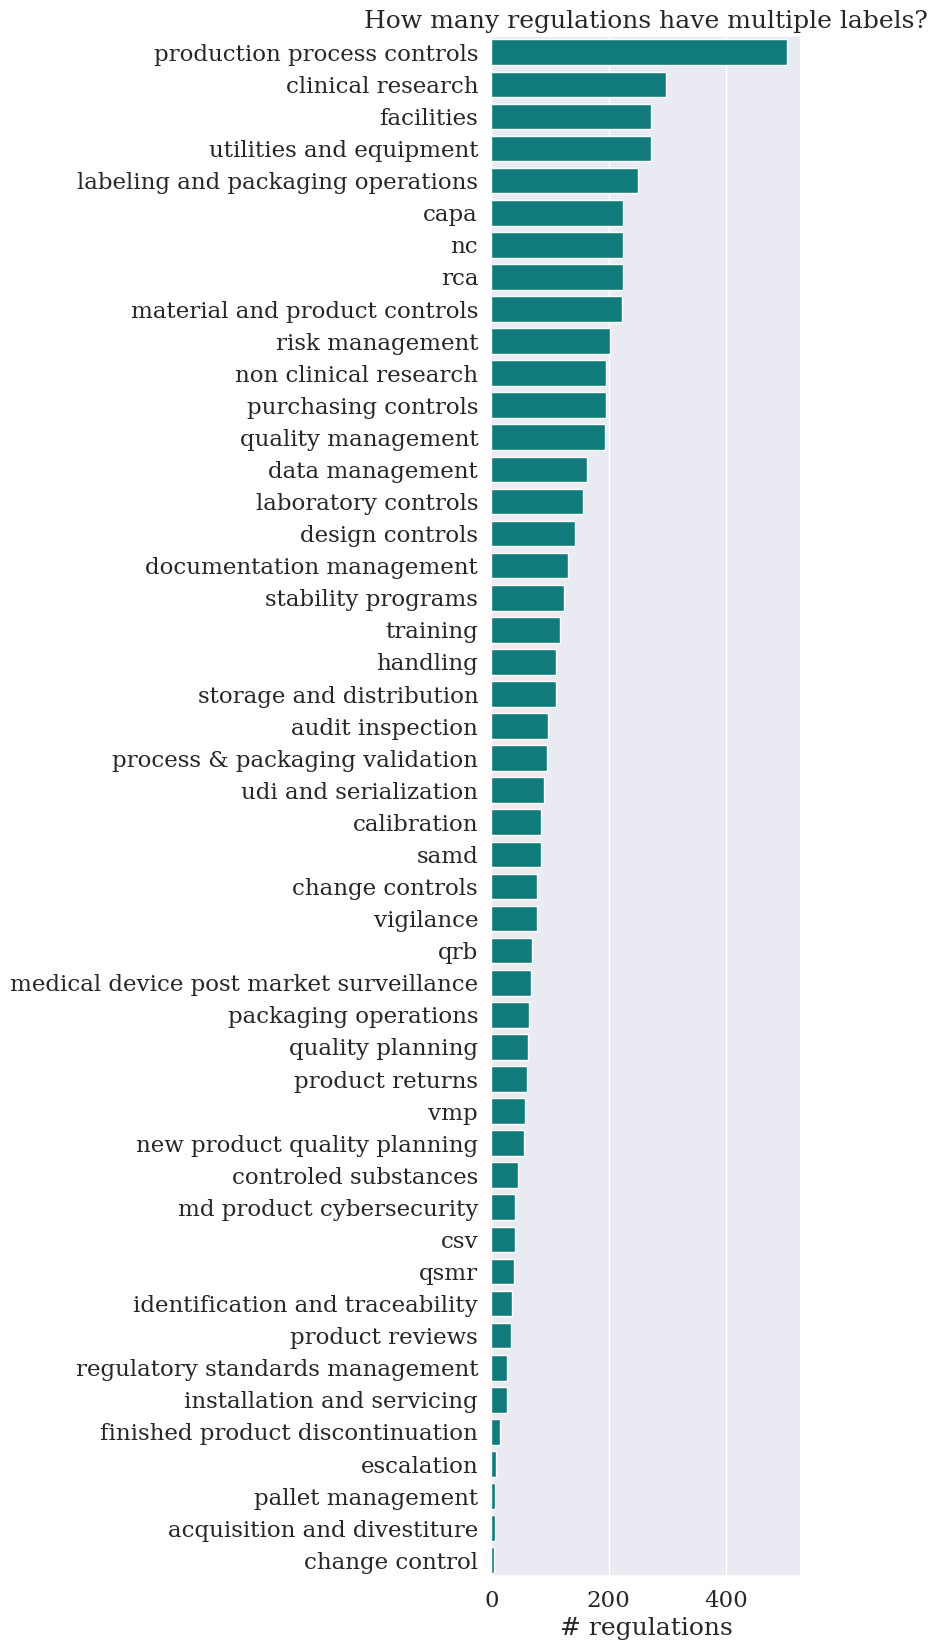

In [41]:
regulation_num_label_counts = sorted(
    list(zip(mlb.classes_, df[mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)
regulations, num_labels = map(list, zip(*regulation_num_label_counts))

plt.figure(figsize=(4, 20))
sns.barplot(x=num_labels, y=regulations, color="darkcyan")
plt.xlabel("# regulations")
plt.title("How many regulations have multiple labels?")
plt.show();

Number of regulations (samples) per label

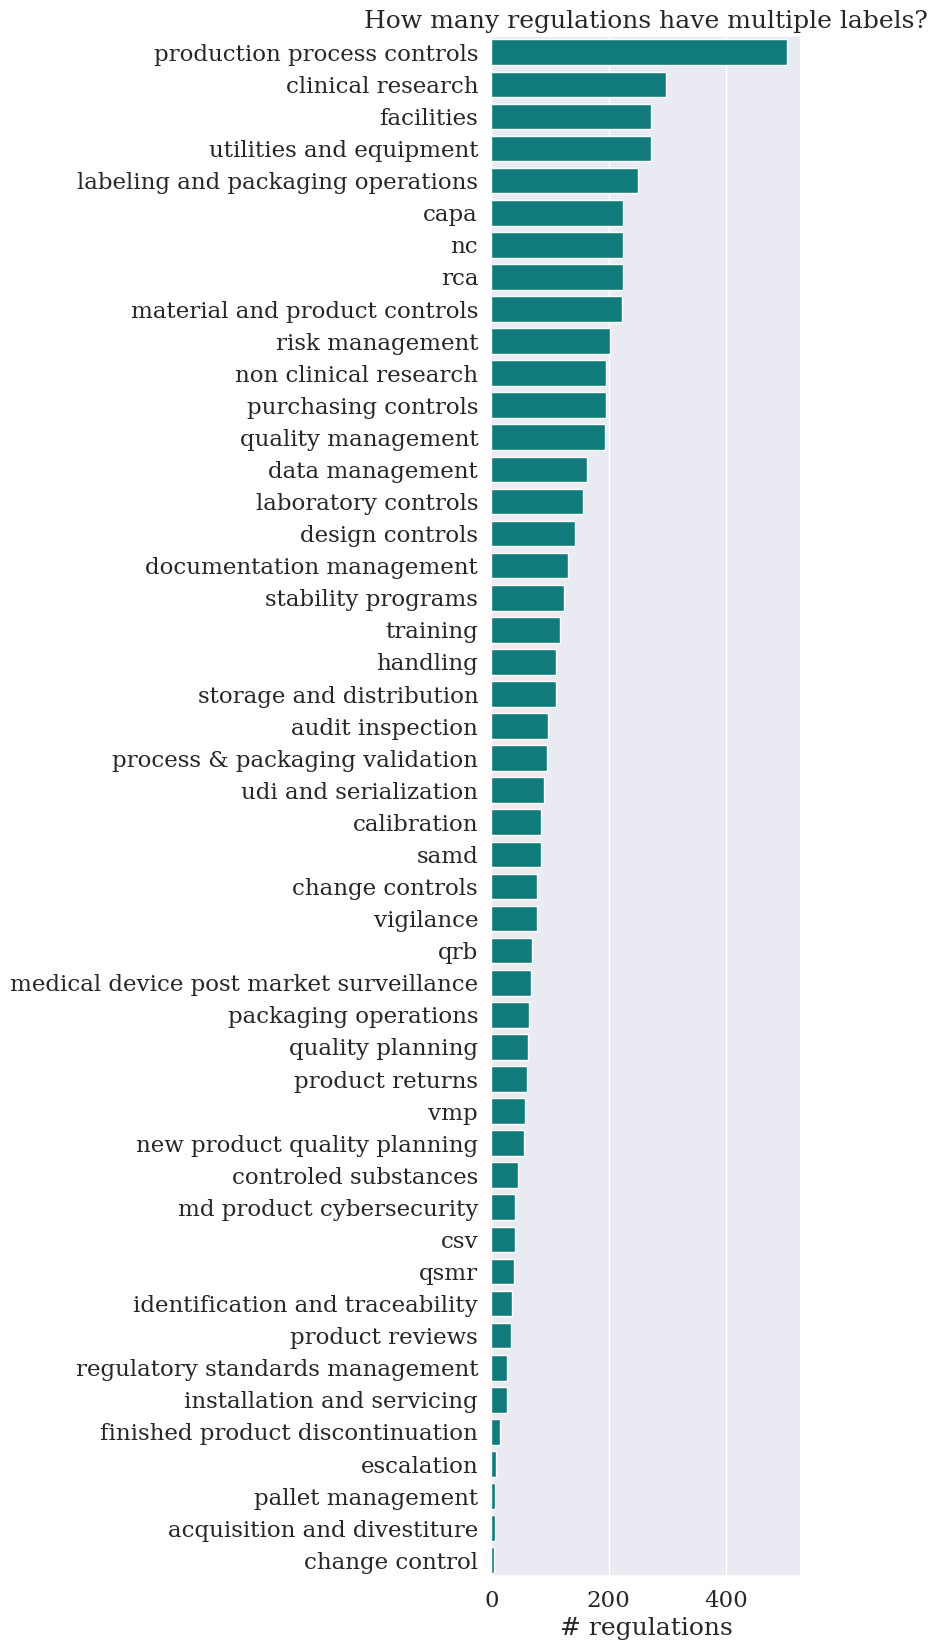

In [42]:
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)
regulations, labels = map(list, zip(*regulation_per_label))

plt.figure(figsize=(4, 20))
sns.barplot(x=labels, y=regulations, color="darkcyan")
plt.xlabel("# regulations")
plt.title("Number of regulations per label")
plt.show();

Number of samples by category for each Regulatory Requirement Type: `Core`, `Non-core`, `Obsolete`

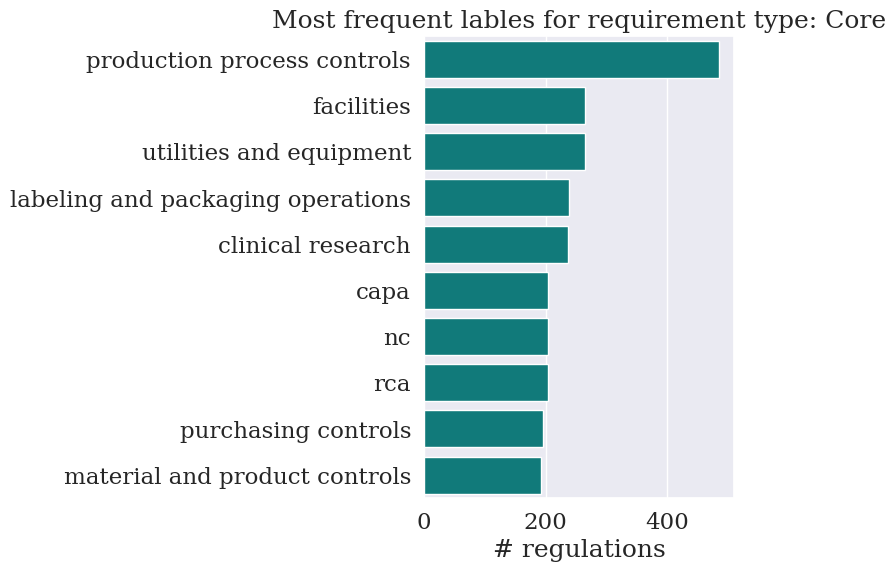

In [53]:
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[df[REQUIREMENT].isin(["Core"])][mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)[0:10]
regulations, labels = map(list, zip(*regulation_per_label))

plt.figure(figsize=(4, 6))
sns.barplot(x=labels, y=regulations, color="darkcyan")
plt.xlabel("# regulations")
plt.title("Most frequent lables for requirement type: Core")
plt.show();

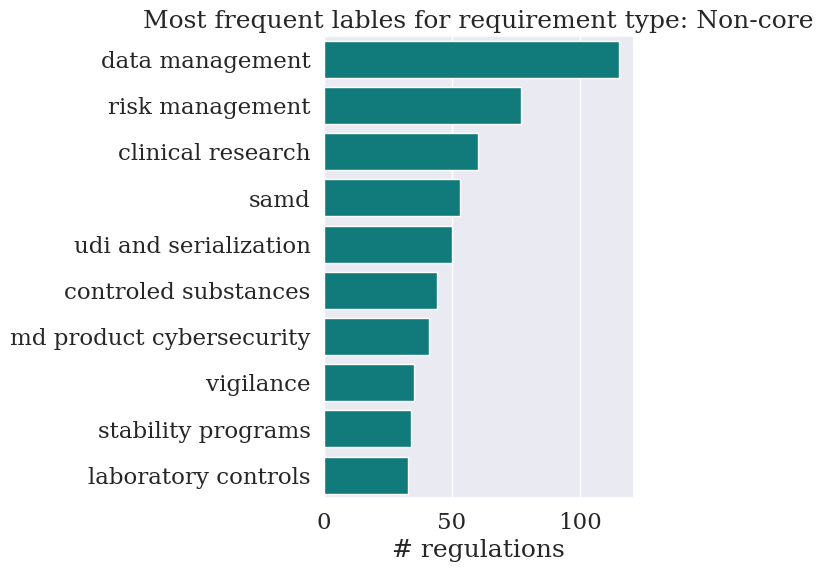

In [57]:
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[df[REQUIREMENT].isin(["Non-core", "Non-Core", "non-core"])][mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)[0:10]
regulations, labels = map(list, zip(*regulation_per_label))

plt.figure(figsize=(4, 6))
sns.barplot(x=labels, y=regulations, color="darkcyan")
plt.xlabel("# regulations")
plt.title("Most frequent lables for requirement type: Non-core")
plt.show();

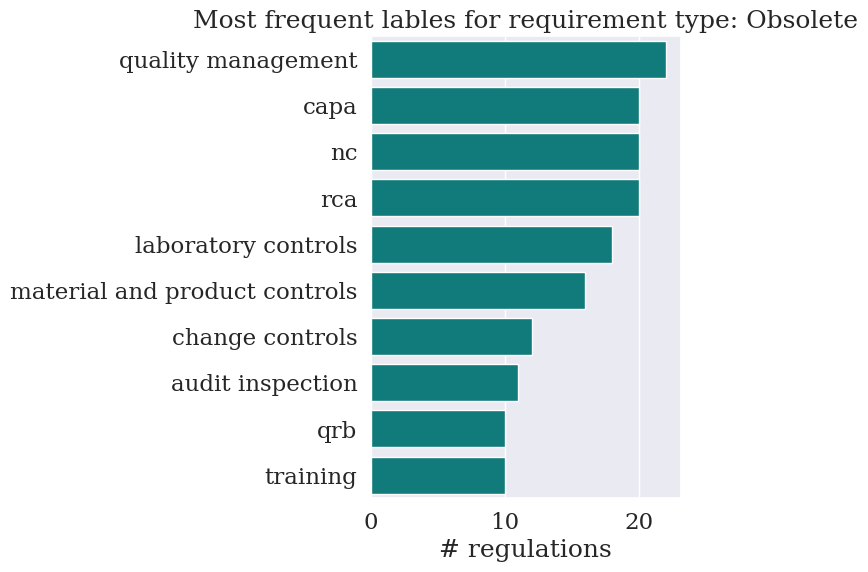

In [59]:
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[df[REQUIREMENT].isin(["Obsolete"])][mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)[0:10]
regulations, labels = map(list, zip(*regulation_per_label))

plt.figure(figsize=(4, 6))
sns.barplot(x=labels, y=regulations, color="darkcyan")
plt.xlabel("# regulations")
plt.title("Most frequent lables for requirement type: Obsolete")
plt.show();

### Regulations - Word analysis

In [427]:
# extract all the words from text, not including numbers
df3 = df2.copy()
for i in range(df3.shape[0]):
    df3['Text'][i] = " ".join(re.sub("([^A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    #df3['Text'][i] = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    df3['Text'][i] = df3['Text'][i].lower().split()
    words = df3['Text'][i]

In [428]:
# exclude all the stop_words including 'shall'
stop_words = set(stopwords.words('english'))
df3['Text'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in df3['Text']]
df3['Text'] = [[word for word in tweet_words if word != 'shall']
              for tweet_words in df3['Text']]

In [429]:
texts = df3['Text']
all_words = list(itertools.chain(*texts))
counts_words = collections.Counter(all_words)
counts_words.most_common(15)

[('quality', 2243),
 ('product', 1661),
 ('control', 1308),
 ('device', 1248),
 ('data', 1127),
 ('products', 1110),
 ('materials', 991),
 ('management', 983),
 ('system', 968),
 ('procedures', 866),
 ('appropriate', 865),
 ('requirements', 864),
 ('production', 863),
 ('manufacturer', 859),
 ('process', 856)]

Text(0.5, 1.0, 'Common Words Found in Texts (Without Stop Words)')

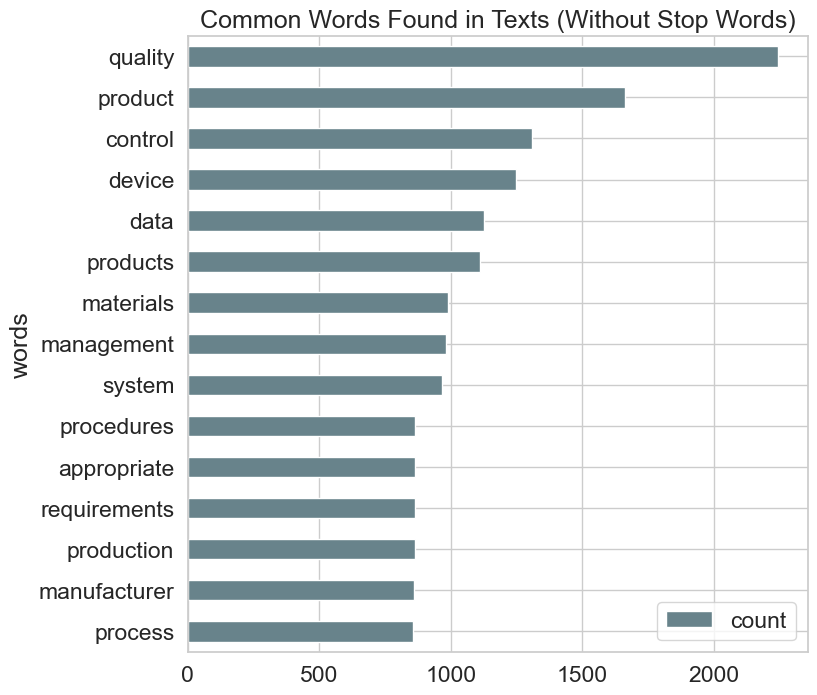

In [430]:
clean_texts = pd.DataFrame(counts_words.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_texts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="#68838B")
ax.set_title("Common Words Found in Texts (Without Stop Words)")


# sentence length analysis

In [431]:
names = list(sorted_dict.keys())
values = list(sorted_dict.values())

In [432]:
lengths = []
counts = []
for name in names:
    count = 0
    length = 0
    for i in range(len(df2['Text'])):
        if name in df2['Standard mapping?'][i]:
            count += 1
            length += len(df2['Text'][i])
    counts.append(count)
    lengths.append(length)          

In [433]:
avg_len = []
for i in range(len(names)):
    if counts[i] == 0:
        print(counts[i])
        avg_len.append(0)
    else:
        avg_len.append(round(lengths[i]/counts[i],2))

In [434]:
data_tuples = list(zip(names,avg_len))
df_len = pd.DataFrame(data_tuples, columns=['labels','avg_len'])

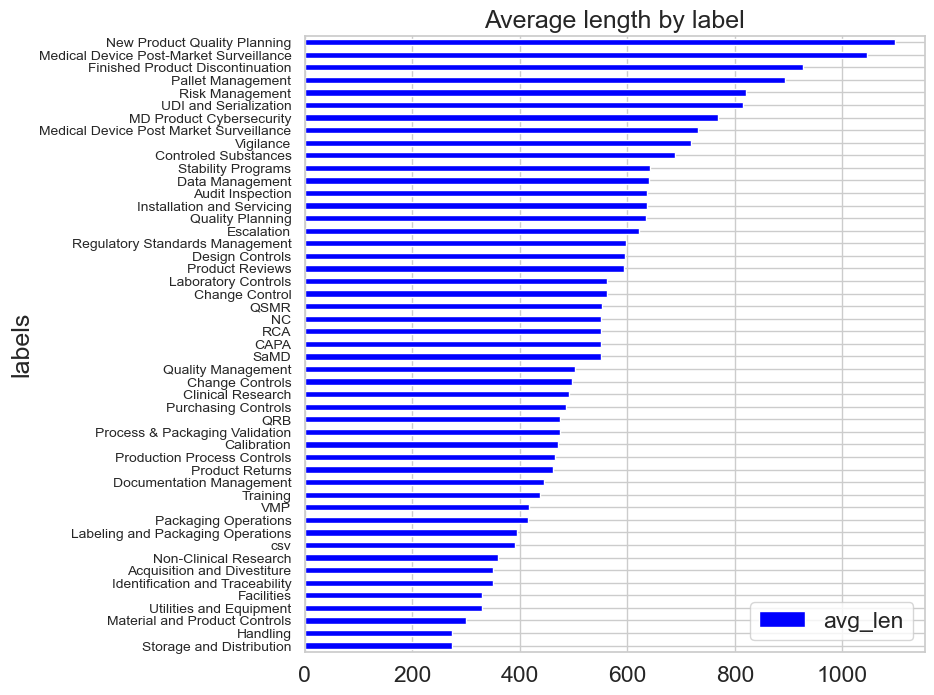

In [435]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_len.sort_values(by='avg_len').plot.barh(x='labels',y='avg_len',ax=ax,
                                         color="blue")
ax.set_title("Average length by label")
ax.yaxis.set_tick_params(labelsize=10)

# distribution of length

In [436]:
df4 = df3.copy()
text_length = []
for i in range(len(df4['Text'])):
    text_length.append(len(df4['Text'][i]))
df4['Text_length'] = text_length

Text(0, 0.5, 'Counts')

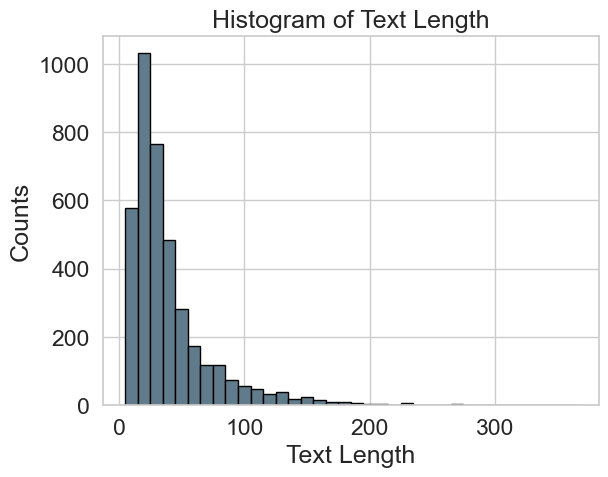

In [437]:
# matplotlib histogram
plt.hist(df4['Text_length'], color = '#607B8B', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Counts')


# N-gram

In [438]:
import re
import nltk
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df1['Text_clean'] = df1.Text.apply(clean_text)

In [439]:
statement = df1['Text_clean'].str.split()
statement=statement.values.tolist()
corpus=[word for i in statement for word in i]
counter=Counter(corpus)
word_freq=counter.most_common()

words, counts = [], []
for word,count in word_freq[:20]:
    words.append(word)
    counts.append(count)


In [440]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq
top_n_bigrams4 = get_top_ngram(df1['Text_clean'],4)[:20] 
ngram_4, count_4 = map(list,zip(*top_n_bigrams4)) 
top_n_bigrams3=get_top_ngram(df1['Text_clean'],3)[:20] 
ngram_3, count_3 = map(list,zip(*top_n_bigrams3)) 
top_n_bigrams2 = get_top_ngram(df1['Text_clean'],2)[:20] 
ngram_2, count_2 = map(list,zip(*top_n_bigrams2)) 

<Figure size 2000x2500 with 0 Axes>

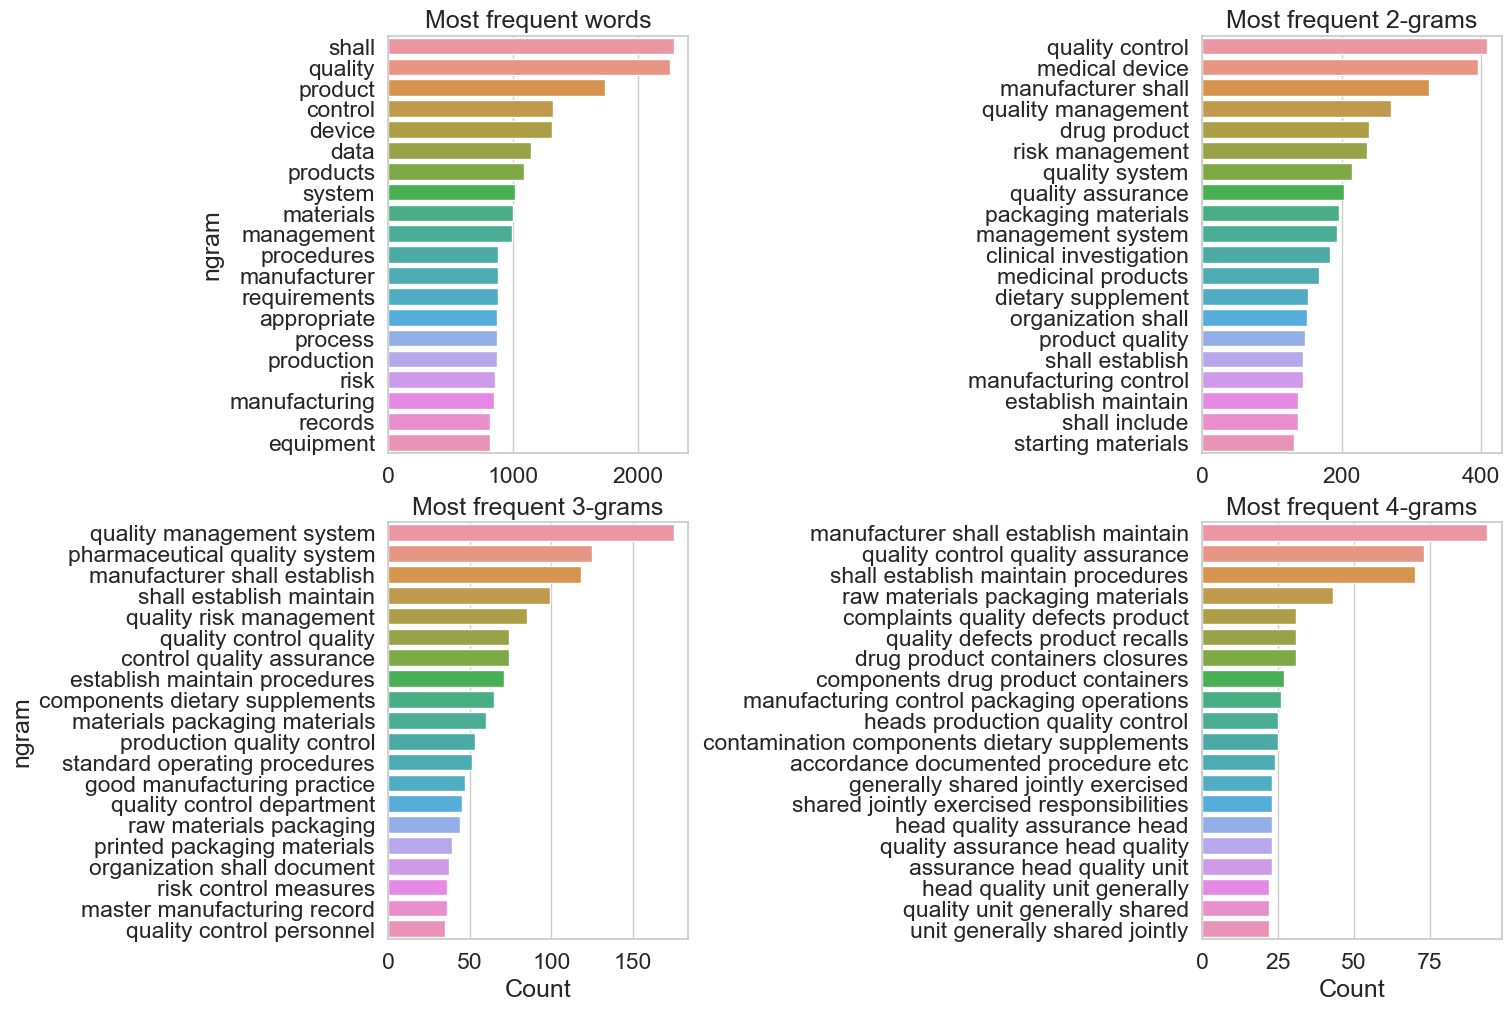

In [441]:
fig = plt.figure()
fig.set_figheight(25) 
fig.set_figwidth(20)
fig,ax = plt.subplots(2, 2, figsize = (15,10), constrained_layout=True)

sns.barplot(x=counts[:20],y=words[:20],ax=ax[0,0])
ax[0,0].set_ylabel('ngram')
ax[0,0].set_title('Most frequent words')

sns.barplot(x=count_2,y=ngram_2, ax=ax[0,1])
ax[0,1].set_title('Most frequent 2-grams')

sns.barplot(x=count_3,y=ngram_3, ax=ax[1,0])
ax[1,0].set_xlabel('Count')
ax[1,0].set_ylabel('ngram')
ax[1,0].set_title('Most frequent 3-grams')

sns.barplot(x=count_4,y=ngram_4, ax=ax[1,1])
ax[1,1].set_xlabel('Count')
ax[1,1].set_title('Most frequent 4-grams')

plt.show()

## N grams for top 3 frequent labels

In [442]:
df5 = df2.copy()
df5.head()

id            Regulation                     Title / Chapter / Sub part  \
0   1  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   
1   2  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   
2   3  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   
3   4  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   
4   5  Brazil ANVISA GMP MD  Chapter 2 General Quality System Requirements   

                Chapter / Section Article / Paragraph  \
0         2.1. General Provisions               2.1.1   
1  2.2. Management responsibility               2.2.1   
2  2.2. Management responsibility               2.2.2   
3  2.2. Management responsibility               2.2.3   
4  2.2. Management responsibility               2.2.4   

                                                Text                 Date  \
0  General Quality System Requirements […] Genera...  2013-03-28 00:00:00   
1  General Quality System Requirements […] Manage...  2013-03-28 00:00:00   
2  General Quality System Requirements […] Manage...  2013-03-28 00:00:00   
3  General Quality System Requirements […] Manage...  2013-03-28 00:00:00   
4  General Quality System Requirements […] Manage...  2013-03-28 00:00:00   

     Product Type  GxP Regulatory Requirement Type  \
0  Medical Device  GMP                        Core   
1  Medical Device  GMP                        Core   
2  Medical Device  GMP                        Core   
3  Medical Device  GMP                        Core   
4  Medical Device  GMP                        Core   

       Full article reference Mapped to a standard?  \
0  Brazil ANVISA GMP MD 2.1.1  Mapped to a standard   
1  Brazil ANVISA GMP MD 2.2.1  Mapped to a standard   
2  Brazil ANVISA GMP MD 2.2.2  Mapped to a standard   
3  Brazil ANVISA GMP MD 2.2.3  Mapped to a standard   
4  Brazil ANVISA GMP MD 2.2.4  Mapped to a standard   

                        Standard mapping?  
0       [Regulatory Standards Management]  
1  [Quality Planning, Quality Management]  
2                    [Quality Management]  
3                    [Quality Management]  
4    [Training, SaMD, Quality Management]

In [443]:
df5.Text = df5.Text.str.replace(r'[^A-Za-z0-9 ]+', '')
df5.Text = df5.Text.str.lower()

In [444]:
sentence_dict = {}
for i in range(df5.shape[0]):
    for j in range(len(df5['Standard mapping?'][i])):
        label = df5['Standard mapping?'][i][j].strip()
        if label == '':
            continue
        if label not in list(sentence_dict.keys()):
            sentence_dict[label] = df5["Text"][i] 
        else:
            sentence_dict[label] += " "
            sentence_dict[label] += df5["Text"][i]

In [445]:
def word_frequency(sentence):
# creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the words, pairs and trigrams
    counted = collections.Counter(new_tokens)
    counted_2= collections.Counter(ngrams(new_tokens,2))
    counted_3= collections.Counter(ngrams(new_tokens,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq, word_pairs, trigrams

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

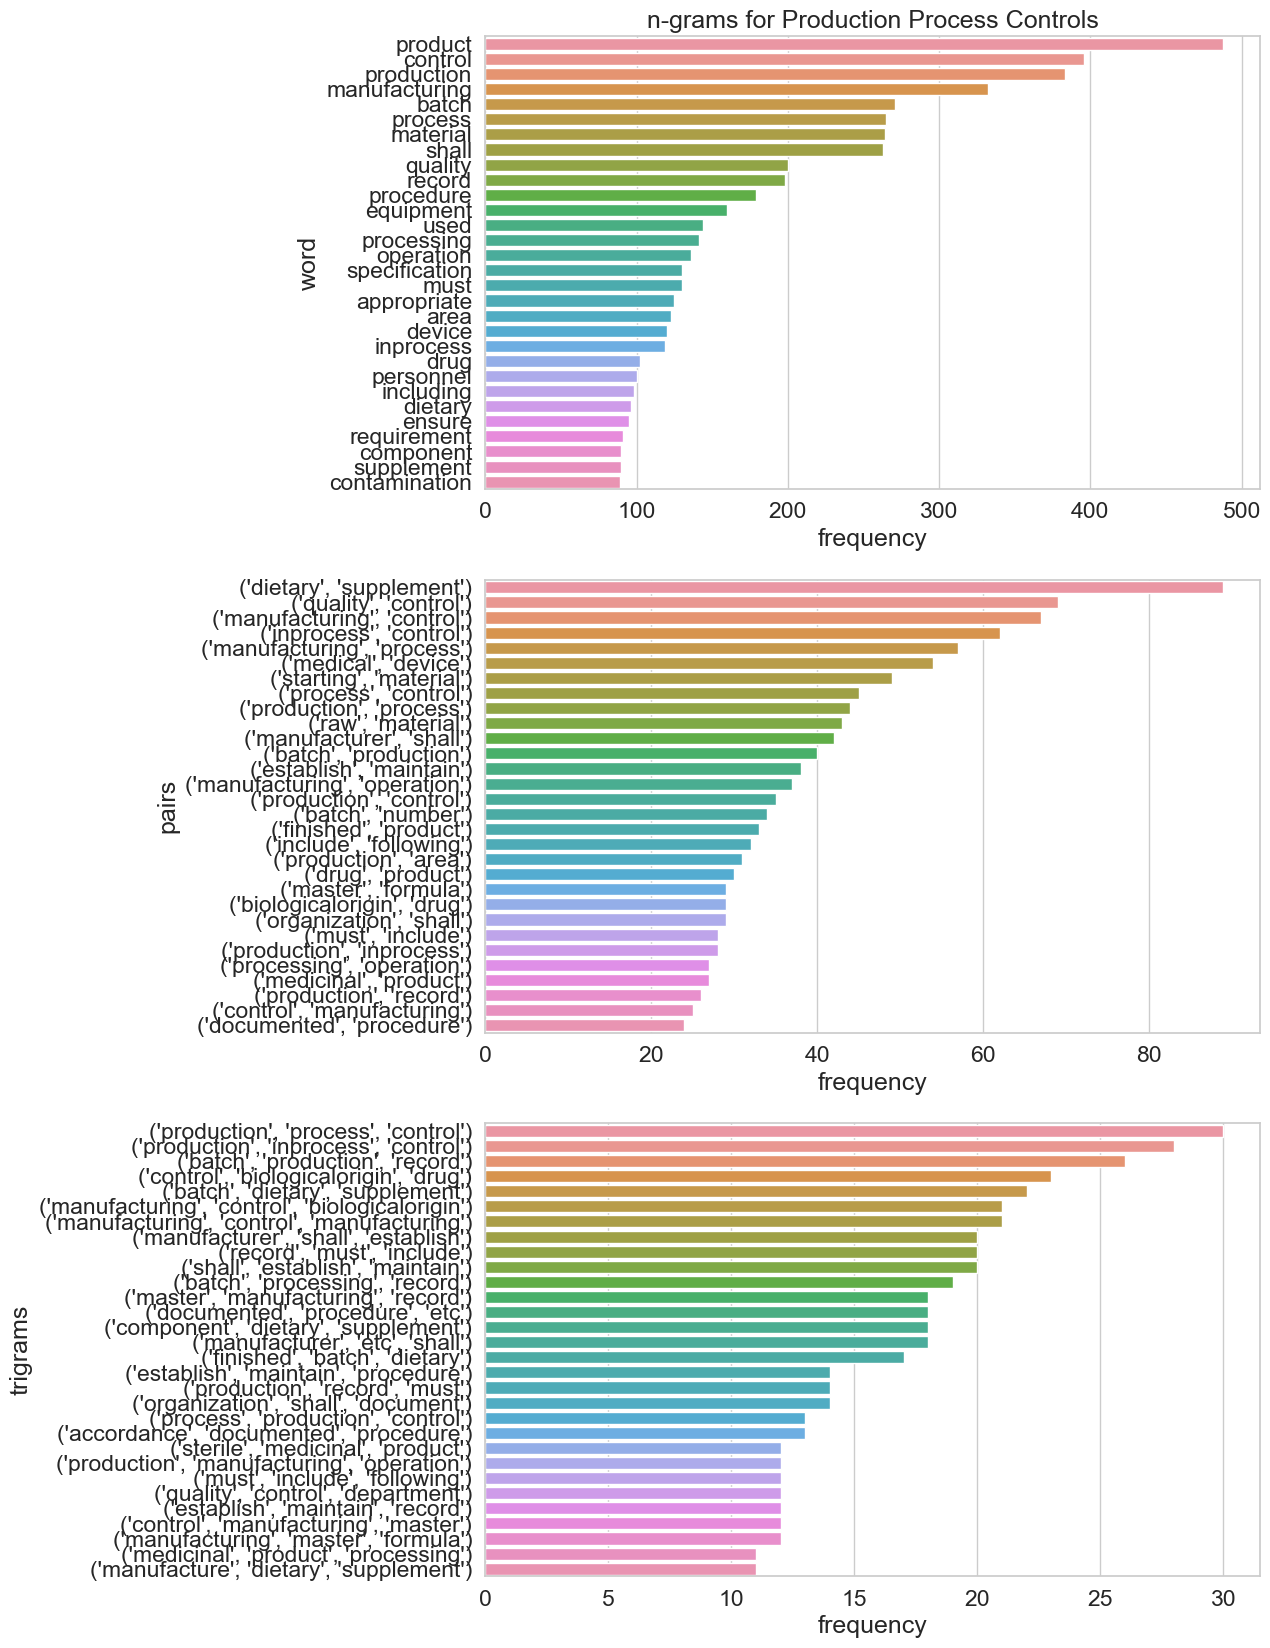

In [446]:
word_freq, word_pairs, trigrams=word_frequency(sentence_dict.get(label_count["label"][0]))
fig, axes = plt.subplots(3,1,figsize=(10,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30)).set(title='n-grams for ' + label_count["label"][0])
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

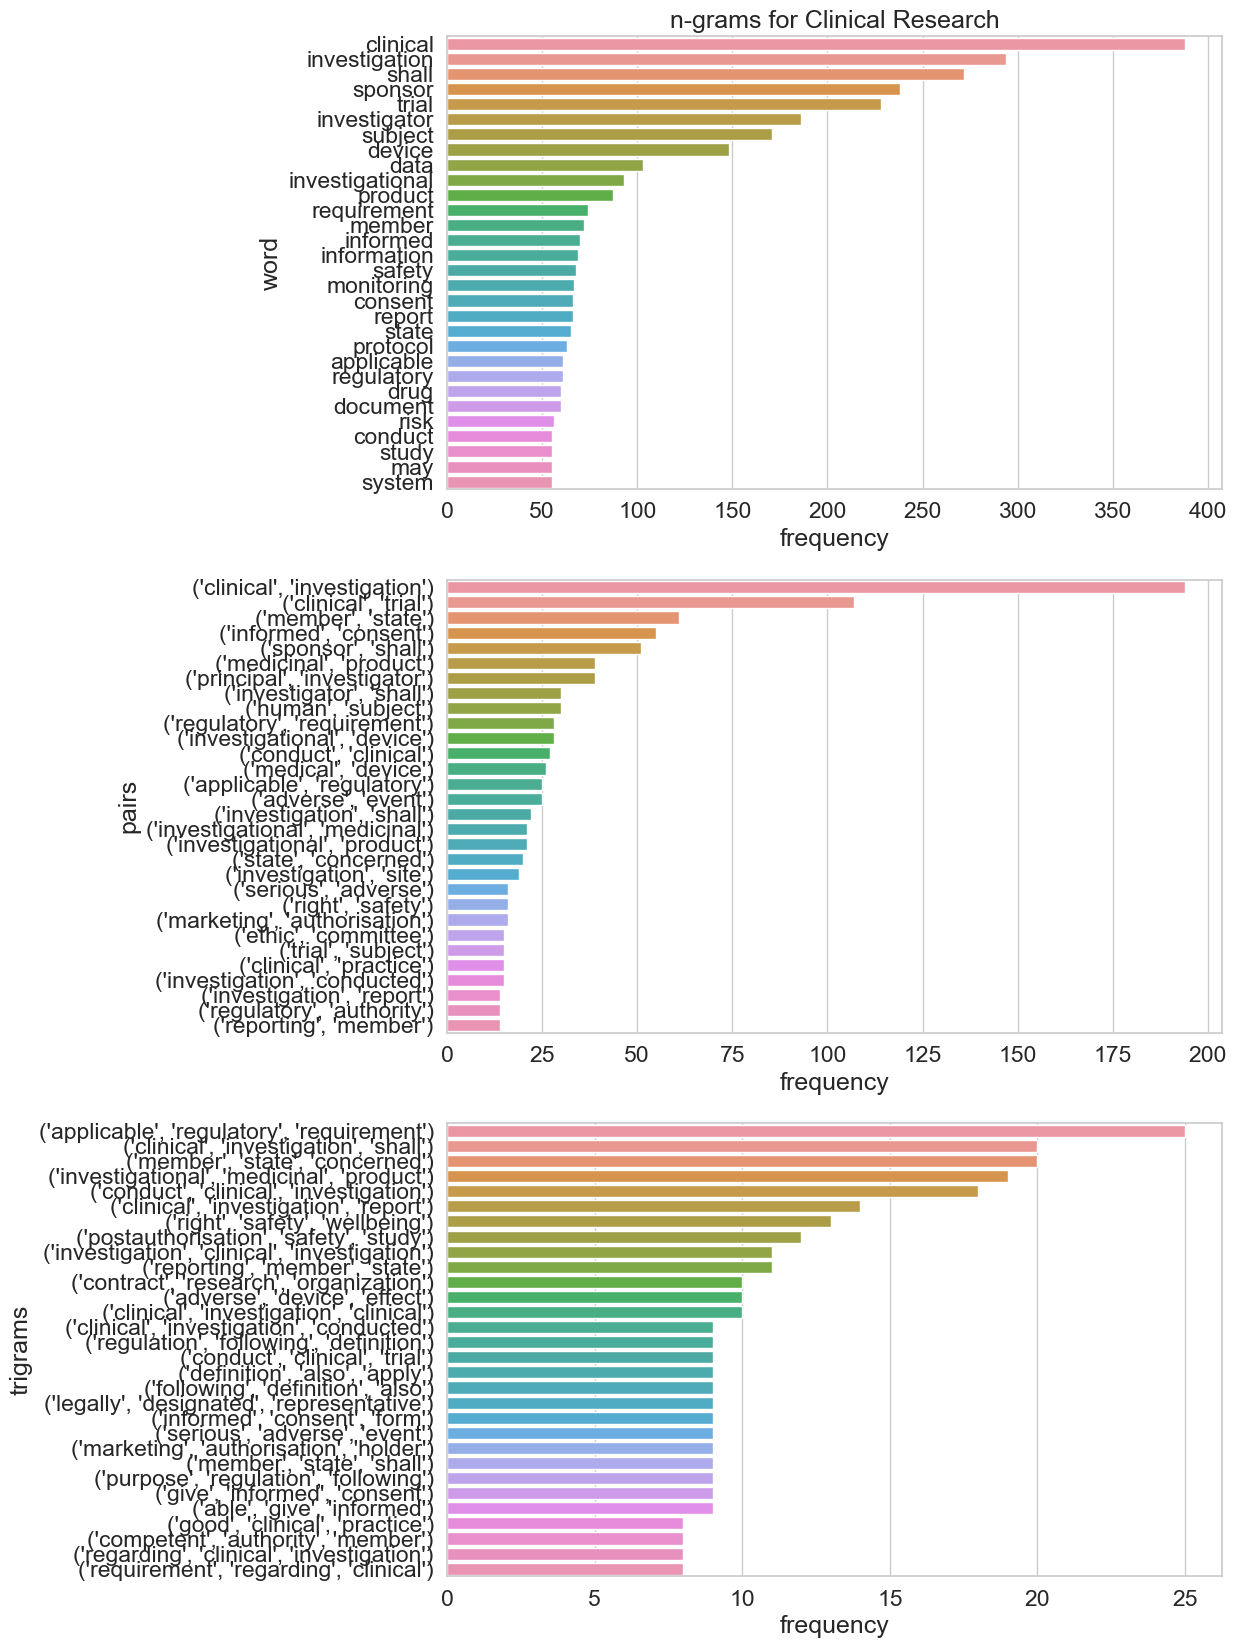

In [447]:
word_freq1, word_pairs1, trigrams1=word_frequency(sentence_dict.get(label_count["label"][1]))
fig, axes = plt.subplots(3,1,figsize=(10,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq1.head(30)).set(title='n-grams for ' + label_count["label"][1])
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs1.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams1.head(30))

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

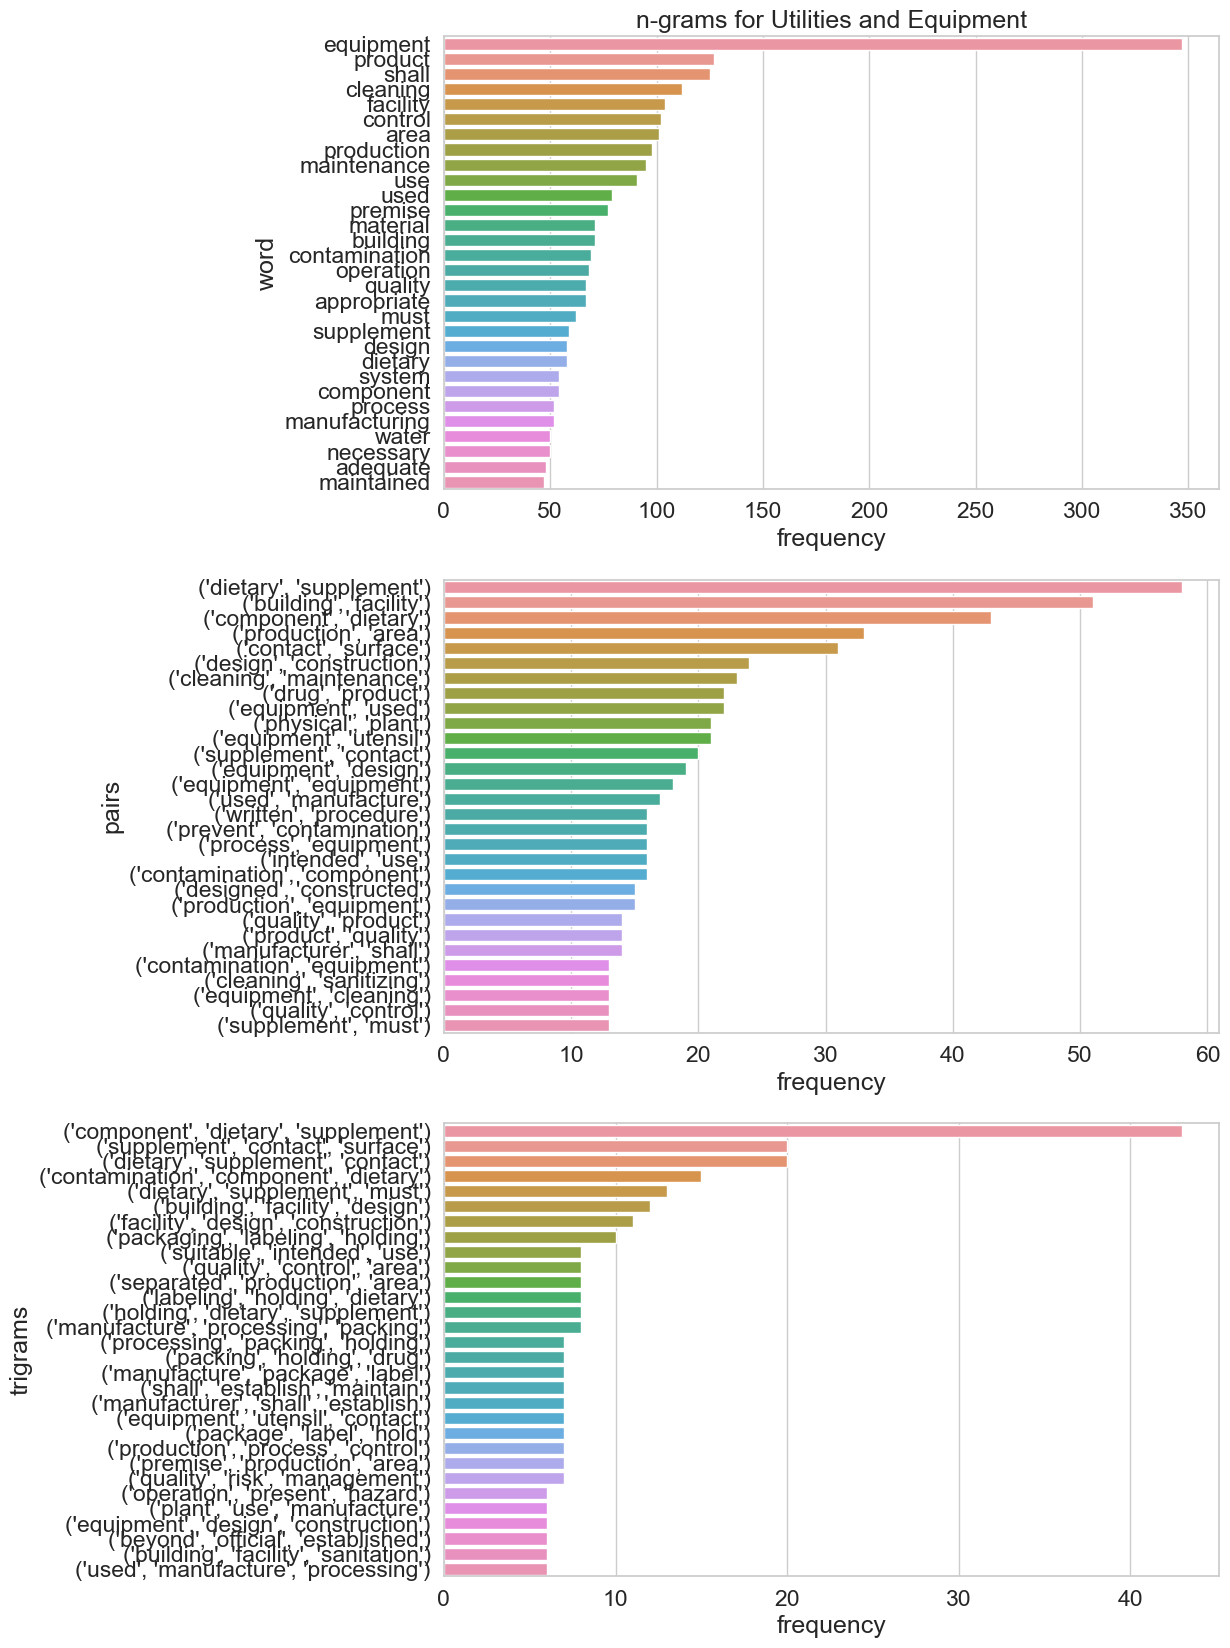

In [448]:
word_freq2, word_pairs2, trigrams2=word_frequency(sentence_dict.get(label_count["label"][2]))
fig, axes = plt.subplots(3,1,figsize=(10,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq2.head(30)).set(title='n-grams for ' + label_count["label"][2])
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs2.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams2.head(30))

# Exploratory of Hygiene Dataset

In [449]:
training_data = pd.read_csv(os.path.join(data.data_path, "jnj_hygiene_ft_training_data.csv"))
training_data.shape

(818, 3)

<AxesSubplot:title={'center':'No.hygiene vs No.other'}, xlabel='completion', ylabel='Count'>

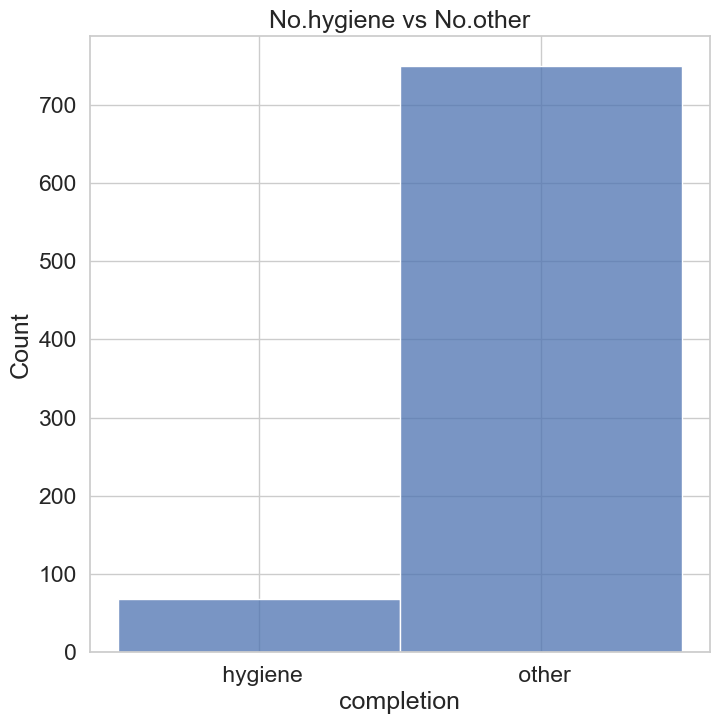

In [450]:
plt.figure(figsize = (8,8))
plt.title("No.hygiene vs No.other")
sns.histplot(training_data, x = "completion")

In [451]:
df = training_data.copy()
for i in range(df.shape[0]):
    df['prompt'][i] = " ".join(re.sub("([^A-Za-z \t])|(\w+:\/\/\S+)", "", df['prompt'][i]).split())
    #df3['Text'][i] = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    df['prompt'][i] = df['prompt'][i].lower().split()
    words = df['prompt'][i]   

In [452]:
df['prompt'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in df['prompt']]
df['prompt'] = [[word for word in tweet_words if word != 'shall' and word != "text"]
              for tweet_words in df['prompt']]

In [453]:
texts = df['prompt']
all_words = list(itertools.chain(*texts))
counts_words = collections.Counter(all_words)
counts_words.most_common(15)

[('product', 445),
 ('quality', 421),
 ('control', 316),
 ('equipment', 286),
 ('packaging', 257),
 ('drug', 251),
 ('procedures', 240),
 ('appropriate', 232),
 ('production', 230),
 ('dietary', 224),
 ('must', 224),
 ('requirements', 208),
 ('records', 207),
 ('materials', 204),
 ('ensure', 197)]

Text(0.5, 1.0, 'Common Words Found in Texts (Without Stop Words)')

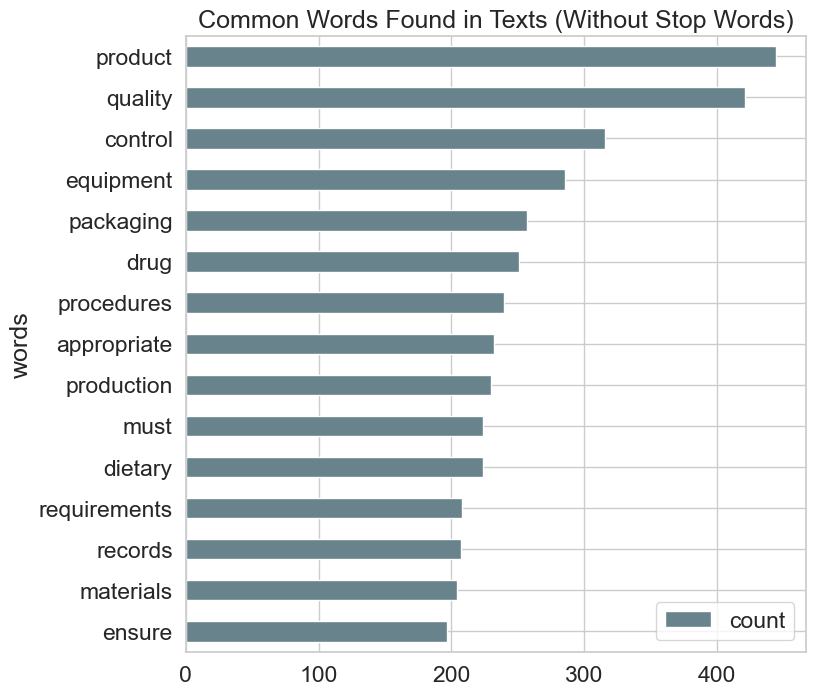

In [454]:
clean_texts = pd.DataFrame(counts_words.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_texts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="#68838B")
ax.set_title("Common Words Found in Texts (Without Stop Words)")

In [455]:
names = ["other", "hygiene"]
values = list(training_data["completion"].value_counts())

In [456]:
lengths = []
counts = []
for name in names:
    count = 0
    length = 0
    for i in range(len(training_data['prompt'])):
        if name in training_data['completion'][i]:
            count += 1
            length += len(training_data['prompt'][i])
    counts.append(count)
    lengths.append(length)  

In [457]:
avg_len = []
for i in range(len(names)):
    if counts[i] == 0:
        print(counts[i])
        avg_len.append(0)
    else:
        avg_len.append(round(lengths[i]/counts[i],2))

In [458]:
data_tuples = list(zip(names,avg_len))
df_len = pd.DataFrame(data_tuples, columns=['labels','avg_len'])

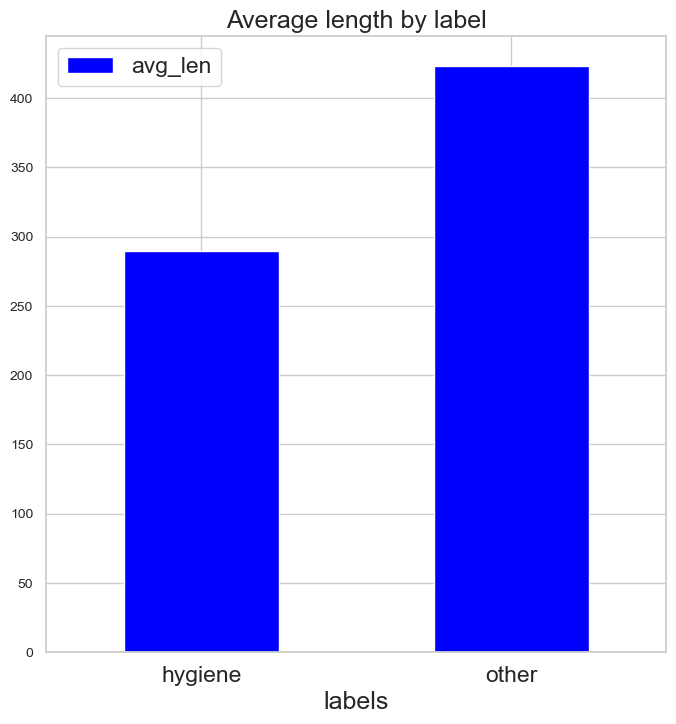

In [459]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_len.sort_values(by='avg_len').plot.bar(x='labels',y='avg_len',ax=ax,
                                         color="blue")
ax.set_title("Average length by label")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(rotation = 0)

In [460]:
df1 = df.copy()
text_length = []
for i in range(len(df1['prompt'])):
    text_length.append(len(df1['prompt'][i]))
df1['Text_length'] = text_length

Text(0, 0.5, 'Counts')

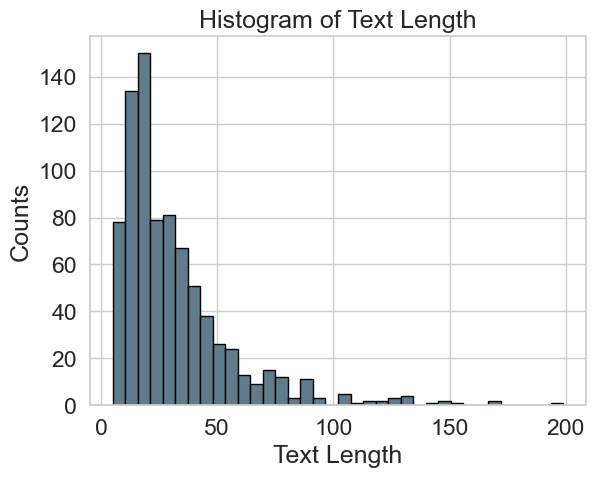

In [461]:
# matplotlib histogram
plt.hist(df1['Text_length'], color = '#607B8B', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Counts')

In [462]:
df2 = training_data.copy()
df2['Text_clean'] = df2.prompt.apply(clean_text)

In [463]:
statement = df2['Text_clean'].str.split()
statement=statement.values.tolist()
corpus=[word for i in statement for word in i]
counter=Counter(corpus)
word_freq=counter.most_common()

words, counts = [], []
for word,count in word_freq[:20]:
    words.append(word)
    counts.append(count)

In [464]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq
top_n_bigrams4 = get_top_ngram(df2['Text_clean'],4)[:20] 
ngram_4, count_4 = map(list,zip(*top_n_bigrams4)) 
top_n_bigrams3=get_top_ngram(df2['Text_clean'],3)[:20] 
ngram_3, count_3 = map(list,zip(*top_n_bigrams3)) 
top_n_bigrams2 = get_top_ngram(df2['Text_clean'],2)[:20] 
ngram_2, count_2 = map(list,zip(*top_n_bigrams2)) 

<Figure size 2000x2500 with 0 Axes>

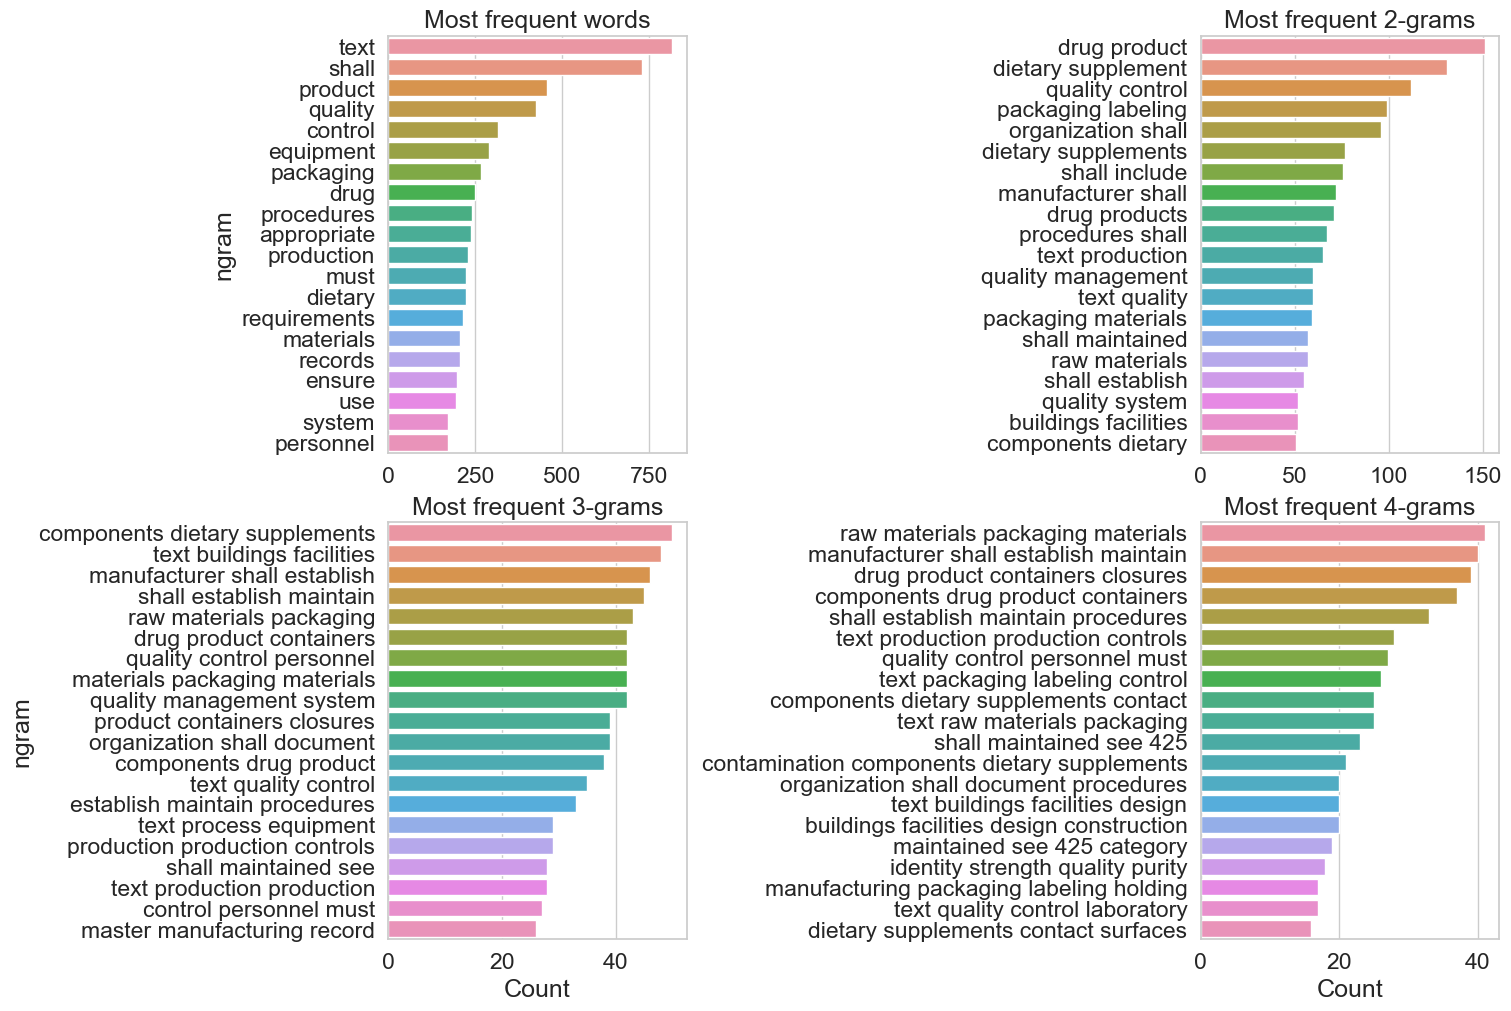

In [465]:
fig = plt.figure()
fig.set_figheight(25) 
fig.set_figwidth(20)
fig,ax = plt.subplots(2, 2, figsize = (15,10), constrained_layout=True)

sns.barplot(x=counts[:20],y=words[:20],ax=ax[0,0])
ax[0,0].set_ylabel('ngram')
ax[0,0].set_title('Most frequent words')

sns.barplot(x=count_2,y=ngram_2, ax=ax[0,1])
ax[0,1].set_title('Most frequent 2-grams')

sns.barplot(x=count_3,y=ngram_3, ax=ax[1,0])
ax[1,0].set_xlabel('Count')
ax[1,0].set_ylabel('ngram')
ax[1,0].set_title('Most frequent 3-grams')

sns.barplot(x=count_4,y=ngram_4, ax=ax[1,1])
ax[1,1].set_xlabel('Count')
ax[1,1].set_title('Most frequent 4-grams')

plt.show()

In [466]:
df3 = training_data.copy()
df3

prompt completion  char_length
0    Text: (2) The sanitation program referred to i...    hygiene          254
1    Text: (3) Washing hands thoroughly (and saniti...    hygiene          269
2    Text: (8) Not eating food, chewing gum, drinki...    hygiene          223
3    Text: (9) Taking any other precautions necessa...    hygiene          311
4    Text: (a)  Your production and in-process cont...      other          524
..                                                 ...        ...          ...
813  Text: You must use equipment and utensils that...      other          733
814  Text: You must use equipment and utensils that...      other          539
815  Text: You must use equipment and utensils that...      other          474
816  Text: You must use equipment and utensils that...      other          690
817  Text: You must use equipment and utensils that...      other          579

[818 rows x 3 columns]

In [467]:

df3.prompt = df3.prompt.str.replace(r'[^A-Za-z0-9 ]+', '')
df3.prompt = df3.prompt.str.lower()

In [468]:
sentence_dict = {}
for i in range(df3.shape[0]):
    label = df3["completion"][i] 
    if label not in list(sentence_dict.keys()):
        sentence_dict[label] = df3["prompt"][i] 
    else:
        sentence_dict[label] += " "
        sentence_dict[label] += df3["prompt"][i]

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

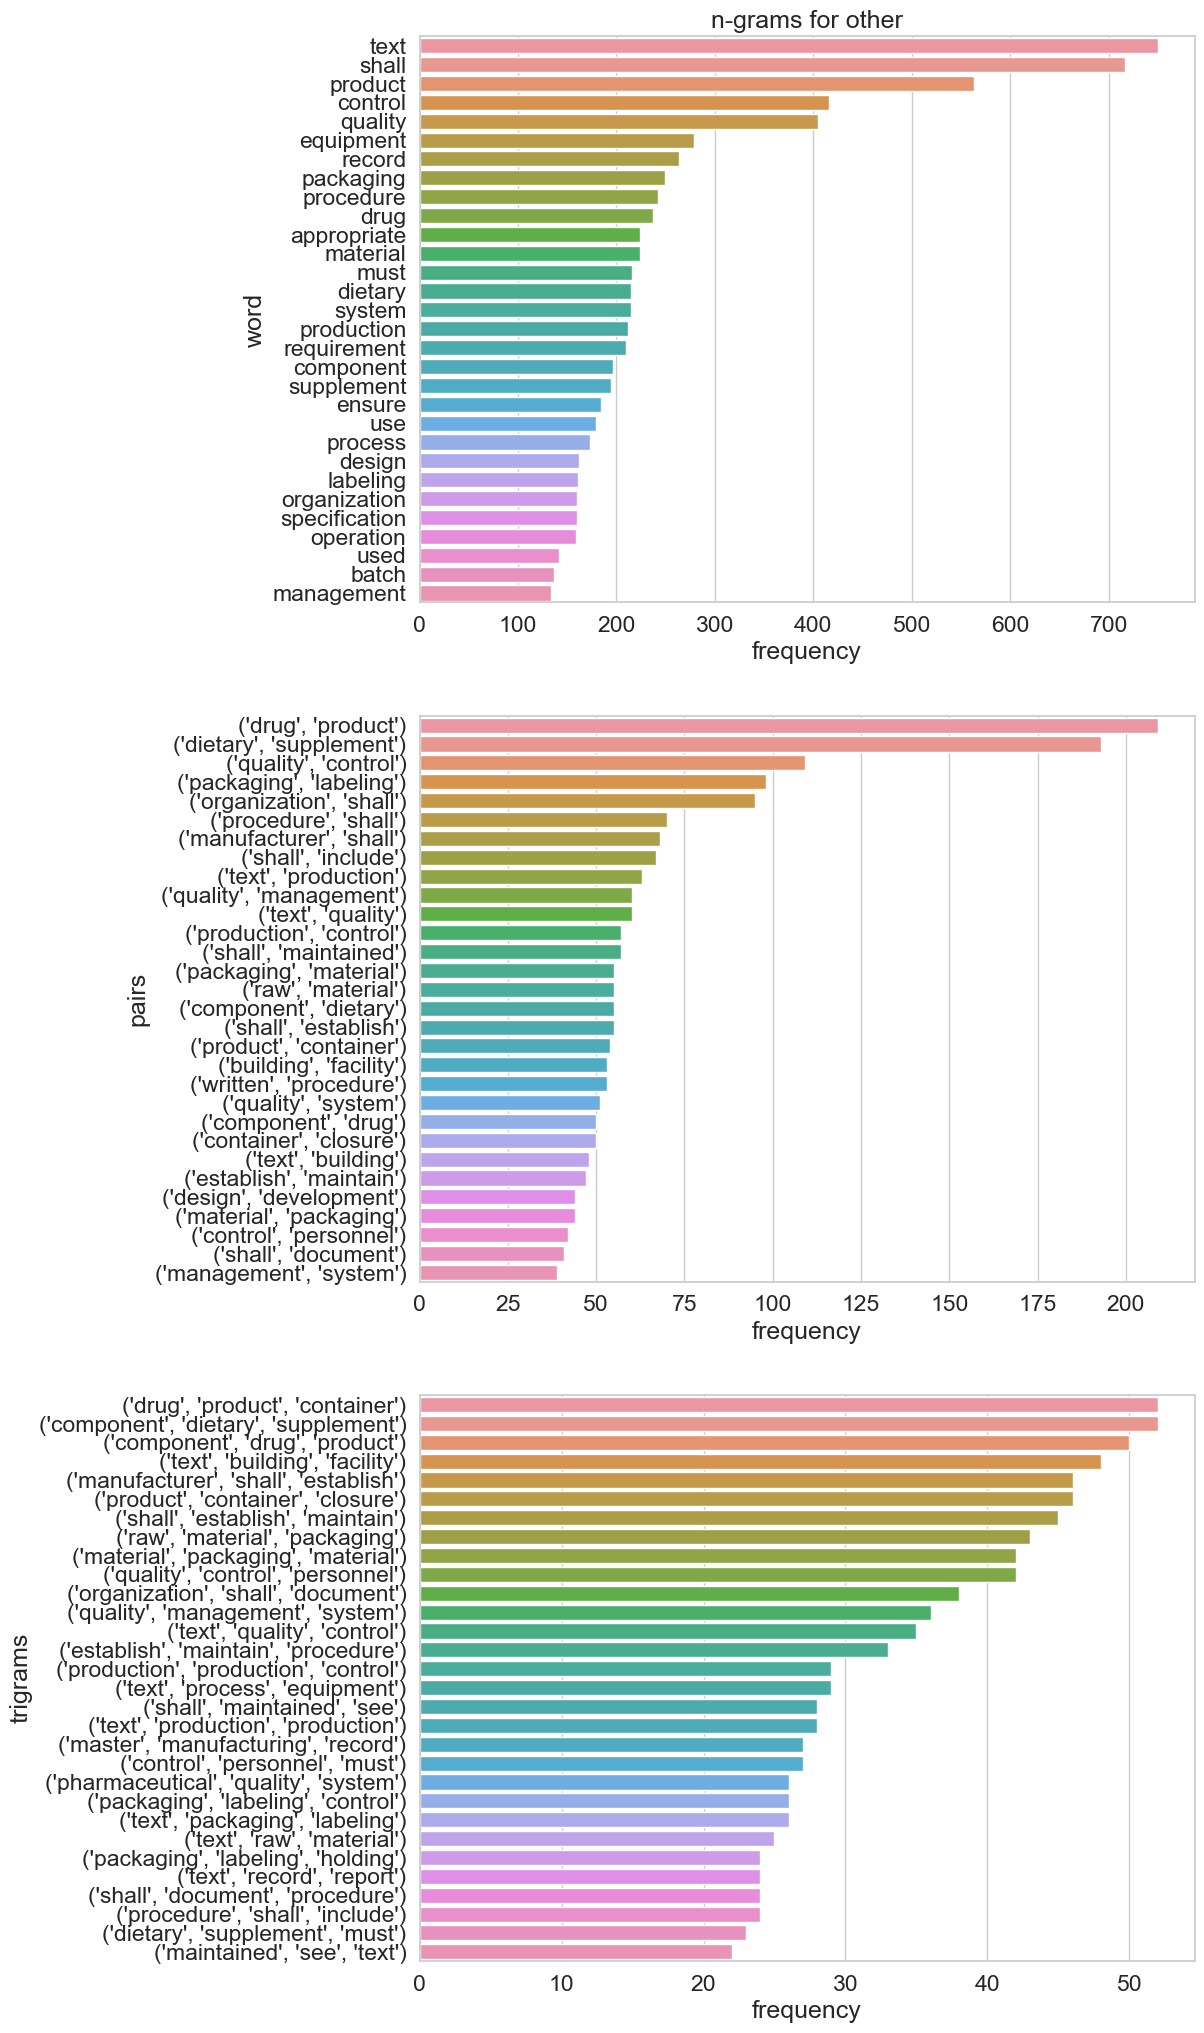

In [469]:
word_freq, word_pairs, trigrams=word_frequency(sentence_dict.get(" other"))
fig, axes = plt.subplots(3,1,figsize=(10,25))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30)).set(title='n-grams for ' + "other")
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

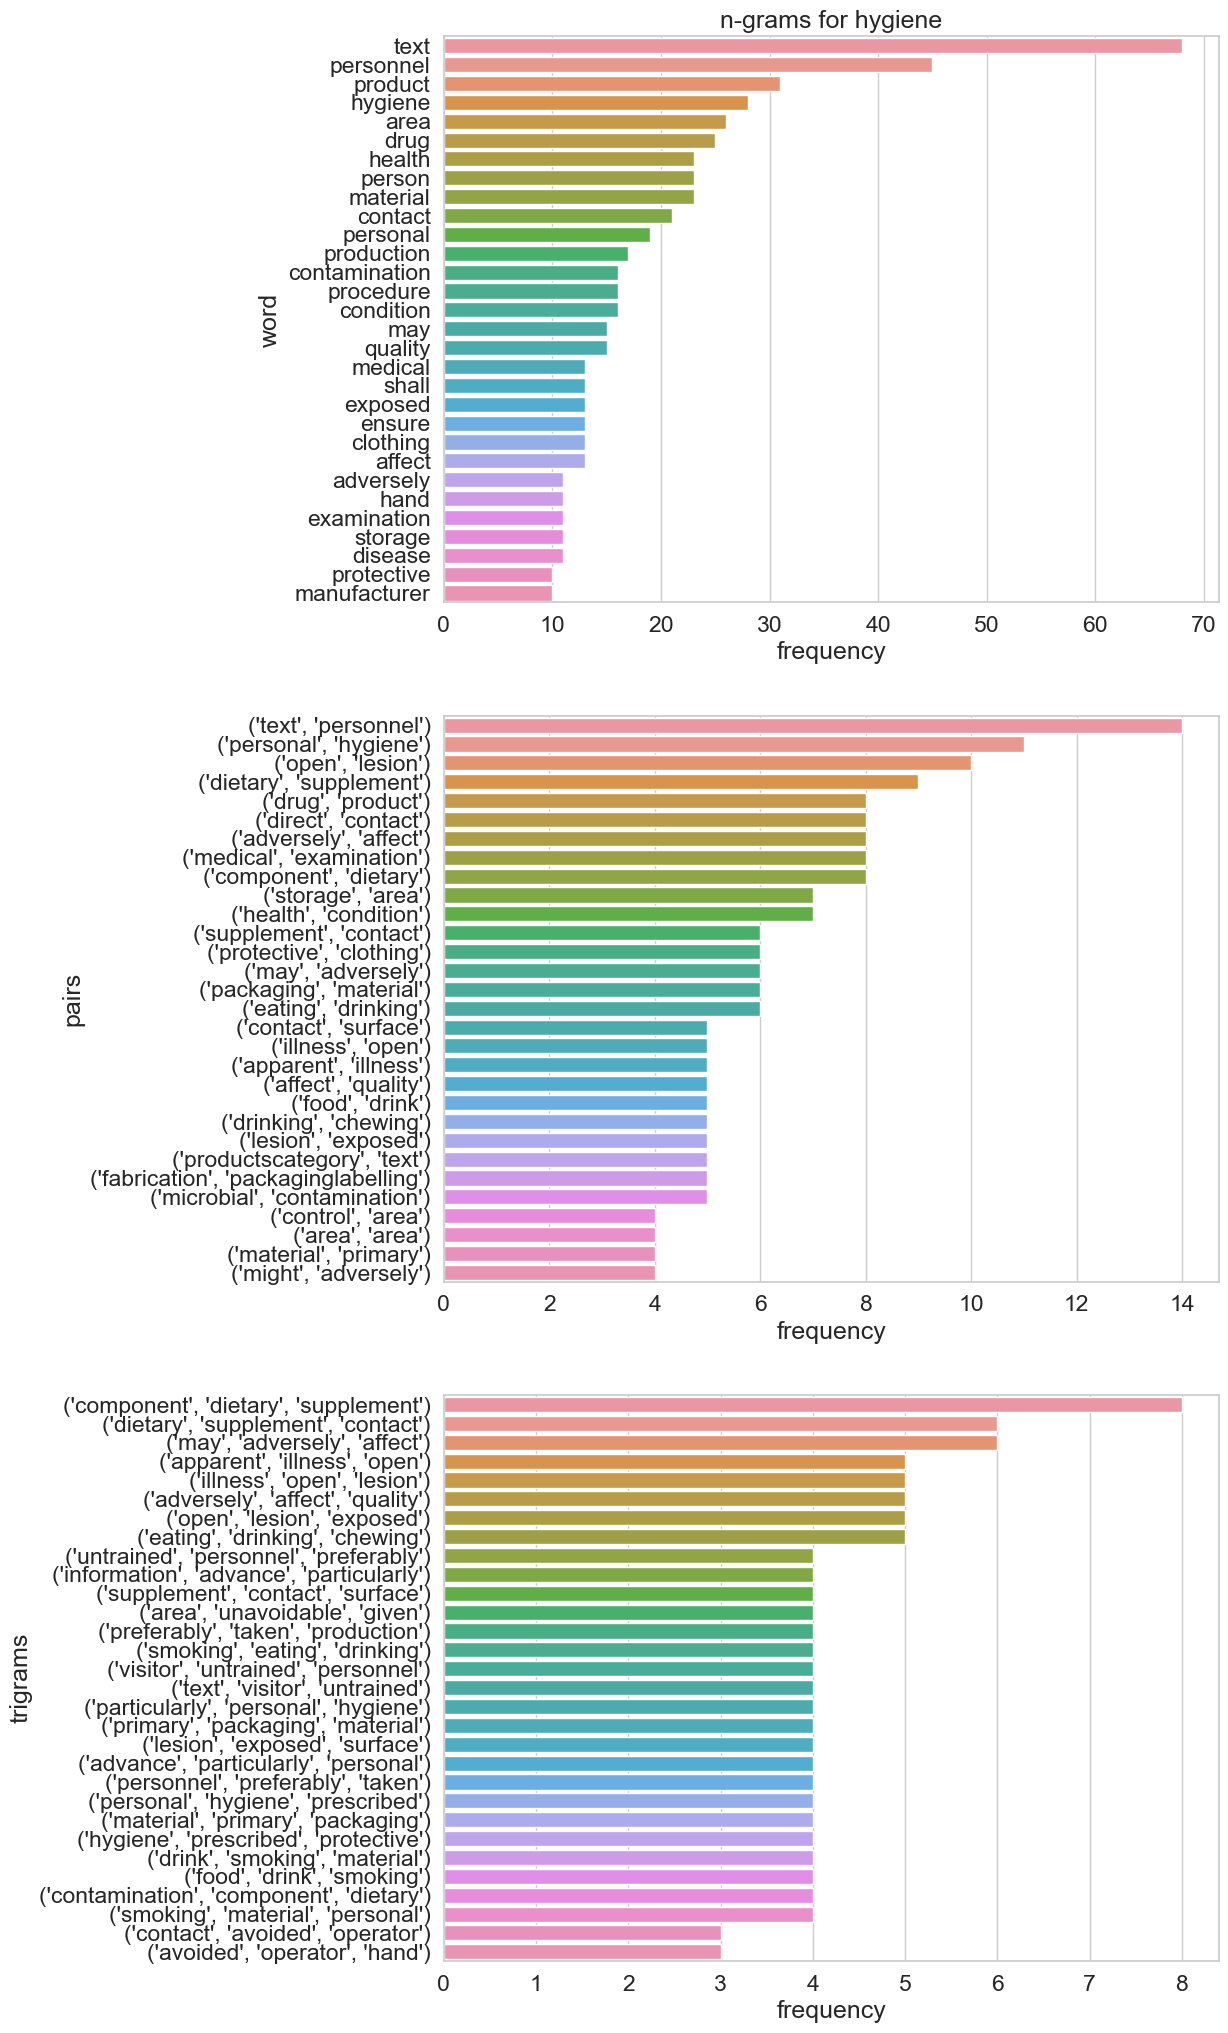

In [470]:
word_freq, word_pairs, trigrams=word_frequency(sentence_dict.get(" hygiene"))
fig, axes = plt.subplots(3,1,figsize=(10,25))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30)).set(title='n-grams for ' + "hygiene")
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))